# Variant Calling Analysis
Beased on [Circulating tumor DNA sequencing in colorectal cancer patients treated with first-line chemotherapy with anti-EGFR](https://www.nature.com/articles/s41598-021-95345-4). 
___

Analysis by: Luis Aguilera. November 15, 2025
_____

## Project Description:
This pipeline analyzes circulating tumor DNA sequencing data to track KRAS mutations in colorectal cancer patients during anti-EGFR treatment. 
This code aims to identify variant allele frequency changes that serve as biomarkers for monitoring treatment response and tumor evolution.
_____

<img src="docs/image.png" alt="VCA pipeline" width="900" />

### Import libraries
___

In [1]:
# importing libraries
import subprocess
from pathlib import Path
import pandas as pd
import numpy as np
import re
from pysradb import SRAweb 
import requests
import pysam
import matplotlib.pyplot as plt

/opt/anaconda3/envs/vca_env/lib/python3.12/site-packages/pysradb/utils.py:14: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


### Paths to data
___

In [2]:
# current working directory
cwd = Path.cwd()
print("Current working directory:", cwd)
# Data directory
data_dir = cwd / "data"
data_dir.mkdir(parents=True, exist_ok=True)
# Genome reference directory
genome_ref_dir = data_dir / "genome_reference"

Current working directory: /Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis


In [3]:
# Utility function to run shell commands
def run_cmd(cmd):
    subprocess.run(cmd, check=True)

### Downloading the reference genome (GRCh38)
___

In [4]:
def download_reference_genome(fasta_url, genome_ref_directory):
    """
    Download and decompress human reference genome.
    Input: fasta_url (str), genome_ref_directory (Path)
    Output: Path to decompressed FASTA file
    """
    # get the name from the URL
    gz_filename = Path(fasta_url).name
    fa_filename = gz_filename.replace(".gz", "")
    gz_path = genome_ref_directory / gz_filename # Path to compressed file
    fa_path = genome_ref_directory / fa_filename # Path to decompressed FASTA file
    if not fa_path.exists():
        if not gz_path.exists():
            # Download the gzipped fasta file
            run_cmd(["wget", "-O", str(gz_path), fasta_url])
        # Decompress the fasta file
        run_cmd(["gunzip", "-k", str(gz_path)])
    else:
        print("Reference genome already exists.")
    return fa_path

# Download reference genome
human_genome_fasta_url = ("https://ftp.ensembl.org/pub/release-109/fasta/homo_sapiens/dna/Homo_sapiens.GRCh38.dna.primary_assembly.fa.gz")
fa_ref_genome_path = download_reference_genome(human_genome_fasta_url, genome_ref_dir)
fa_ref_genome_path

Reference genome already exists.


PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/genome_reference/Homo_sapiens.GRCh38.dna.primary_assembly.fa')

### Get metadata for bioproject: PRJNA714799
___

In [5]:
# Download SRA metadata for project PRJNA714799
metadata_file_path = data_dir.joinpath("SRA_metadata_PRJNA714799_full.csv")
if metadata_file_path.exists():
    metadata = pd.read_csv(metadata_file_path)
else:
    db = SRAweb()
    metadata = db.sra_metadata("PRJNA714799", detailed=True)
    metadata.to_csv(metadata_file_path, index=False)
metadata.head()

,run_accession,study_accession,study_title,experiment_accession,experiment_title,experiment_desc,organism_taxid,organism_name,library_name,library_strategy,...,biomaterial_provider,sex,tissue,biosamplemodel,ena_fastq_http,ena_fastq_http_1,ena_fastq_http_2,ena_fastq_ftp,ena_fastq_ftp_1,ena_fastq_ftp_2
0,SRR13973703,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351697,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_267,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_267,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
1,SRR13973704,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351696,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_266,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_266,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
2,SRR13973705,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351695,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_265,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_265,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
3,SRR13973706,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351694,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,PBMC_35,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,PBMC_35,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...
4,SRR13973707,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351693,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_264,Targeted-Capture,...,"03080, 101, Daehak-ro, Jongno-gu, Seoul, Repub...",not applicable,plasma_264,Human,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...


In [6]:
# Extract sample type and ID from 'tissue' column
metadata['sample_type'] = metadata['tissue'].str.extract(r'^([A-Za-z]+)_')[0]
metadata['sample_id'] = metadata['tissue'].str.extract(r'_(\d+)$')[0].astype(int)
print(f"{metadata['sample_type'].value_counts().to_string()}\n")
print(f"Unique patient IDs: {metadata['sample_id'].nunique()}\n")
print(f"{metadata['isolate'].value_counts().to_string()}")


sample_type
plasma        271
PBMC           76
colorectal     73

Unique patient IDs: 271

isolate
blood            347
tissue biopsy     73


### Extracting patient_id and timepoints from metadata
___

The SRA metadata use a consistent `run_alias` pattern:

- PBMC samples: `PBMC_<ID>.final.bam`  
  patient_id = <ID>, sample_type = PBMC, no timepoint

- FFPE tumor samples: `FFPE_<ID>.final.bam`  
  patient_id = <ID>, sample_type = Tissue, no timepoint

- ctDNA samples: `<ID>.final.bam` or `<ID>-<N>.final.bam`  
  patient_id = <ID>, sample_type = ctDNA, timepoint 0 (no suffix) or timepoint N (suffix -N)


In [7]:
def extract_patient_info_from_alias(run_alias):
    """
    Extract patient_id, timepoint, and sample_type from run_alias.
    Input: run_alias (str)
    Output: dict with keys patient_id, timepoint, sample_type
    """
    if pd.isna(run_alias):
        return {"patient_id": None, "timepoint": None, "sample_type": None}
    if run_alias.startswith("PBMC_"):
        patient_id = run_alias.replace("PBMC_", "").replace(".final.bam", "")
        return {"patient_id": patient_id, "timepoint": None, "sample_type": "PBMC"}
    if run_alias.startswith("FFPE_"):
        patient_id = run_alias.replace("FFPE_", "").replace(".final.bam", "")
        return {"patient_id": patient_id, "timepoint": None, "sample_type": "Tissue"}
    ctdna_pattern = re.match(r'^(CTC\d+|C_fw\d+)(?:-(\d+))?\.final\.bam$', run_alias)
    if ctdna_pattern:
        patient_id = ctdna_pattern.group(1)
        timepoint = 0 if ctdna_pattern.group(2) is None else int(ctdna_pattern.group(2))
        return {"patient_id": patient_id, "timepoint": timepoint, "sample_type": "ctDNA"}
    return {"patient_id": None, "timepoint": None, "sample_type": None}

def add_patient_info_to_metadata(input_metadata):
    """
    Add patient_id, timepoint, and sample_type columns to metadata.
    Input: input_metadata (pd.DataFrame)
    Output: pd.DataFrame with added patient information columns
    """
    output_metadata = input_metadata.copy()
    parsed_info = output_metadata['run_alias'].apply(extract_patient_info_from_alias)
    parsed_df = pd.DataFrame(parsed_info.tolist())
    columns_to_drop = ["patient_id", "timepoint", "sample_type"]
    existing_columns = [col for col in columns_to_drop if col in output_metadata.columns]
    if existing_columns:
        output_metadata = output_metadata.drop(columns=existing_columns)
    output_metadata = pd.concat([output_metadata, parsed_df], axis=1)
    return output_metadata
# Parse metadata and add patient information
metadata = add_patient_info_to_metadata(metadata)
metadata.head()

,run_accession,study_accession,study_title,experiment_accession,experiment_title,experiment_desc,organism_taxid,organism_name,library_name,library_strategy,...,ena_fastq_http,ena_fastq_http_1,ena_fastq_http_2,ena_fastq_ftp,ena_fastq_ftp_1,ena_fastq_ftp_2,sample_id,patient_id,timepoint,sample_type
0,SRR13973703,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351697,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_267,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/003...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,267,CTC362,2.0,ctDNA
1,SRR13973704,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351696,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_266,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/004...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,266,CTC360,0.0,ctDNA
2,SRR13973705,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351695,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_265,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/005...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,265,CTC360,2.0,ctDNA
3,SRR13973706,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351694,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,PBMC_35,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/006...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,35,CTC003,NaN,PBMC
4,SRR13973707,SRP310811,plasma cfdna sequencing in CRC treated with 1s...,SRX10351693,plasma cfdna sequencing in CRC treated with 1s...,plasma cfdna sequencing in CRC treated with 1s...,9606,Homo sapiens,plasma_264,Targeted-Capture,...,NaN,ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007/SRR139...,http://ftp.sra.ebi.ac.uk/vol1/fastq/SRR139/007...,NaN,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,era-fasp@fasp.sra.ebi.ac.uk:vol1/fastq/SRR139/...,264,CTC358,0.0,ctDNA


In [8]:
def filter_ctdna_samples(metadata_dataframe):
    """
    Filter metadata to only ctDNA samples.
    Input: metadata_dataframe (pd.DataFrame)
    Output: pd.DataFrame with ctDNA samples and integer timepoints
    """
    ctdna_samples = metadata_dataframe[metadata_dataframe["sample_type"] == "ctDNA"].copy()
    ctdna_samples["timepoint"] = ctdna_samples["timepoint"].astype(int)
    return ctdna_samples
# Filter to ctDNA samples only
ctdna = filter_ctdna_samples(metadata)

In [9]:
def find_eligible_patients(ctdna_dataframe):
    """
    Find patients with at least 3 timepoints including baseline (0).
    Input: ctdna_dataframe (pd.DataFrame)
    Output: pd.DataFrame with eligible patients and their timepoints
    """
    eligible_patients_list = []
    for patient_id, patient_group in ctdna_dataframe.groupby("patient_id"):
        timepoints = sorted(patient_group["timepoint"].dropna().unique())
        timepoints = [int(tp) for tp in timepoints]
        has_baseline = 0 in timepoints
        has_followup = any(tp > 0 for tp in timepoints)
        has_three_timepoints = len(timepoints) >= 3
        if has_baseline and has_followup and has_three_timepoints:
            eligible_patients_list.append((patient_id, timepoints))
    
    eligible_df = pd.DataFrame(eligible_patients_list, columns=["patient_id", "timepoints"])
    eligible_df["n_timepoints"] = eligible_df["timepoints"].apply(len)
    return eligible_df
# Find eligible patients
eligible_df = find_eligible_patients(ctdna)
eligible_df.sort_values("n_timepoints", ascending=True).head(10)

,patient_id,timepoints,n_timepoints
0,CTC002,"[0, 2, 5]",3
29,CTC258,"[0, 2, 5]",3
30,CTC259,"[0, 3, 6]",3
31,CTC267,"[0, 2, 3]",3
32,CTC271,"[0, 2, 3]",3
33,CTC276,"[0, 2, 11]",3
34,CTC277,"[0, 2, 6]",3
35,CTC281,"[0, 2, 3]",3
36,CTC292,"[0, 2, 10]",3
37,CTC309,"[0, 2, 9]",3


In [10]:
def annotate_clinical_timepoints(patient_dataframe):
    """
    Annotate timepoints with clinical phase labels.
    Input: patient_dataframe (pd.DataFrame)
    Output: pd.DataFrame with added tp_label column
    """
    output_df = patient_dataframe.copy()
    output_df["timepoint"] = output_df["timepoint"].astype(int)
    unique_timepoints = sorted(output_df["timepoint"].unique())
    baseline_timepoint = 0
    first_followup_timepoint = min(tp for tp in unique_timepoints if tp > 0)
    last_timepoint = max(tp for tp in unique_timepoints if tp > 0)
    def get_clinical_label(timepoint_value):
        if timepoint_value == baseline_timepoint:
            return "pre_treatment"
        elif timepoint_value == first_followup_timepoint:
            return "during_treatment"
        elif timepoint_value == last_timepoint:
            return "post_treatment"
        return None
    output_df["tp_label"] = output_df["timepoint"].apply(get_clinical_label)
    return output_df.sort_values("timepoint")
# Select and annotate one patient
selected_patient_id = "CTC030"
patient_data = ctdna[ctdna["patient_id"] == selected_patient_id]
patient_data_annotated = annotate_clinical_timepoints(patient_data)
# Display results
patient_data_annotated[["run_accession", "run_alias", "timepoint", "tp_label"]]

,run_accession,run_alias,timepoint,tp_label
108,SRR13973811,CTC030.final.bam,0,pre_treatment
110,SRR13973813,CTC030-2.final.bam,2,during_treatment
109,SRR13973812,CTC030-6.final.bam,6,post_treatment


In [11]:
def download_single_fastq_file(download_url, output_file_path):
    """
    Download a FASTQ file if it doesn't already exist.
    Input: download_url (str), output_file_path (Path)
    Output: bool (True if downloaded, False if skipped)
    """
    if output_file_path.exists():
        print(f"Skipping {output_file_path.name} (already exists)")
        return False
    print(f"Downloading {output_file_path.name}...")
    run_cmd(["wget", "-O", str(output_file_path), download_url])
    return True

def download_fastq_files_for_patient(patient_annotated_dataframe, patient_identifier, 
                                      data_directory, timepoints_to_include=None):
    """
    Download paired FASTQ files (R1 and R2) for a patient.
    Input: patient_annotated_dataframe (pd.DataFrame), patient_identifier (str), 
           data_directory (Path), timepoints_to_include (list, optional)
    Output: Path (directory containing downloaded files)
    """
    if timepoints_to_include is None:
        timepoints_to_include = ["pre_treatment", "during_treatment", "post_treatment"]
    patient_directory = data_directory / patient_identifier
    patient_directory.mkdir(parents=True, exist_ok=True)
    for _, sample_row in patient_annotated_dataframe.iterrows():
        timepoint_label = sample_row["tp_label"]
        if timepoint_label not in timepoints_to_include:
            continue
        r1_url = sample_row["ena_fastq_http_1"]
        r2_url = sample_row["ena_fastq_http_2"]
        if pd.notna(r1_url) and r1_url != "":
            r1_file_path = patient_directory / f"{patient_identifier}_{timepoint_label}_R1.fastq.gz"
            download_single_fastq_file(r1_url, r1_file_path)
        if pd.notna(r2_url) and r2_url != "":
            r2_file_path = patient_directory / f"{patient_identifier}_{timepoint_label}_R2.fastq.gz"
            download_single_fastq_file(r2_url, r2_file_path)
    return patient_directory

# Download FASTQ files for the selected patient
patient_data_directory = download_fastq_files_for_patient(
    patient_annotated_dataframe=patient_data_annotated,
    patient_identifier=selected_patient_id,
    data_directory=data_dir
)

Skipping CTC030_pre_treatment_R1.fastq.gz (already exists)
Skipping CTC030_pre_treatment_R2.fastq.gz (already exists)
Skipping CTC030_during_treatment_R1.fastq.gz (already exists)
Skipping CTC030_during_treatment_R2.fastq.gz (already exists)
Skipping CTC030_post_treatment_R1.fastq.gz (already exists)
Skipping CTC030_post_treatment_R2.fastq.gz (already exists)


In [12]:
def organize_fastq_files_by_timepoint(patient_directory, patient_identifier):
    """
    Organize FASTQ files into nested dictionary by timepoint.
    Input: patient_directory (Path), patient_identifier (str)
    Output: dict with structure {timepoint: {'R1': Path, 'R2': Path}}
    """
    organized_fastq_paths = {}
    filename_pattern = re.compile(
        rf"^{re.escape(patient_identifier)}_(.+)_R([12])\.fastq\.gz$"
    )
    for file_path in patient_directory.iterdir():
        if not file_path.name.endswith(".fastq.gz"):
            continue
        match = filename_pattern.match(file_path.name)
        if match is None:
            continue
        timepoint_label = match.group(1)
        read_number = match.group(2)
        if timepoint_label not in organized_fastq_paths:
            organized_fastq_paths[timepoint_label] = {}
        organized_fastq_paths[timepoint_label][f"R{read_number}"] = file_path
    return organized_fastq_paths

# Organize FASTQ files for alignment
fastq_paths = organize_fastq_files_by_timepoint(
    patient_directory=patient_data_directory,
    patient_identifier=selected_patient_id
)
fastq_paths

{'pre_treatment': {'R2': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_pre_treatment_R2.fastq.gz'),
  'R1': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_pre_treatment_R1.fastq.gz')},
 'post_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_post_treatment_R1.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_post_treatment_R2.fastq.gz')},
 'during_treatment': {'R1': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_during_treatment_R1.fastq.gz'),
  'R2': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/CTC030/CTC030_during_treatment_R2.fastq.gz')}}

### Perform alignment
___

In [13]:
def build_bwa_index(reference_fasta_path):
    """
    Build BWA index for reference genome.
    Input: reference_fasta_path (Path or str)
    Output: None
    """
    reference_fasta_path = Path(reference_fasta_path)
    index_extensions = [".amb", ".ann", ".bwt", ".pac", ".sa"]
    index_file_paths = [
        reference_fasta_path.with_suffix(reference_fasta_path.suffix + ext)
        for ext in index_extensions
    ]
    if all(index_file.exists() for index_file in index_file_paths):
        print("BWA index already exists.")
        return
    print("Building BWA index...")
    run_cmd(["bwa", "index", str(reference_fasta_path)])

def align_reads_to_reference(sample_label, forward_reads_path, reverse_reads_path,
                              reference_fasta_path, output_directory, patient_identifier):
    """
    Align paired-end reads to reference genome using BWA-MEM.
    Input: sample_label (str), forward_reads_path (Path), reverse_reads_path (Path),
           reference_fasta_path (Path), output_directory (Path), patient_identifier (str)
    Output: Path to sorted BAM file
    """
    output_directory = Path(output_directory)
    output_directory.mkdir(parents=True, exist_ok=True)
    sorted_bam_path = output_directory / f"{patient_identifier}_{sample_label}.sorted.bam"
    bam_index_path = sorted_bam_path.with_suffix(".bam.bai")
    if sorted_bam_path.exists() and bam_index_path.exists():
        print(f"Skipping {sorted_bam_path.name} (already aligned)")
        return sorted_bam_path
    print(f"Aligning {sample_label}...")
    bwa_mem_command = [
        "bwa", "mem", "-t", "10",
        str(reference_fasta_path),
        str(forward_reads_path),
        str(reverse_reads_path)
    ]
    process_bwa = subprocess.Popen(bwa_mem_command, stdout=subprocess.PIPE)
    process_view = subprocess.Popen(
        ["samtools", "view", "-b", "-@", "4"],
        stdin=process_bwa.stdout,
        stdout=subprocess.PIPE
    )
    process_sort = subprocess.Popen(
        ["samtools", "sort", "-@", "4", "-o", str(sorted_bam_path)],
        stdin=process_view.stdout
    )
    process_sort.communicate()
    process_bwa.stdout.close()
    process_view.stdout.close()
    run_cmd(["samtools", "index", "-@", "4", str(sorted_bam_path)])
    return sorted_bam_path

# Build BWA index for reference genome
build_bwa_index(fa_ref_genome_path)
# Align all samples
bam_output_directory = data_dir / "bam" / selected_patient_id
aligned_bam_paths = {}
for timepoint_label, fastq_file_paths in fastq_paths.items():
    aligned_bam_paths[timepoint_label] = align_reads_to_reference(
        sample_label=timepoint_label,
        forward_reads_path=fastq_file_paths["R1"],
        reverse_reads_path=fastq_file_paths["R2"],
        reference_fasta_path=fa_ref_genome_path,
        output_directory=bam_output_directory,
        patient_identifier=selected_patient_id
    )
aligned_bam_paths

BWA index already exists.
Skipping CTC030_pre_treatment.sorted.bam (already aligned)
Skipping CTC030_post_treatment.sorted.bam (already aligned)
Skipping CTC030_during_treatment.sorted.bam (already aligned)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_pre_treatment.sorted.bam'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_post_treatment.sorted.bam'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_during_treatment.sorted.bam')}

### Duplicate removal
___

In [14]:
def mark_duplicate_reads(input_bam_path, output_bam_path):
    """
    Mark duplicate reads in BAM file using samtools.
    Input: input_bam_path (Path), output_bam_path (Path)
    Output: Path to deduplicated BAM file
    """
    output_bam_path = Path(output_bam_path)
    output_bam_index = output_bam_path.with_suffix(".bam.bai")
    if output_bam_path.exists() and output_bam_index.exists():
        print(f"Skipping {output_bam_path.name} (already marked)")
        return output_bam_path
    print(f"Marking duplicates for {input_bam_path.name}...")
    name_sorted_bam = str(input_bam_path).replace(".bam", ".name_sorted.bam")
    fixmate_bam = str(input_bam_path).replace(".bam", ".fixmate.bam")
    run_cmd(["samtools", "sort", "-n", "-@", "4", "-o", name_sorted_bam, str(input_bam_path)])
    run_cmd(["samtools", "fixmate", "-m", "-@", "4", name_sorted_bam, fixmate_bam])
    run_cmd(["samtools", "sort", "-@", "4", "-o", str(output_bam_path), fixmate_bam])
    run_cmd(["samtools", "markdup", "-@", "4", str(output_bam_path), str(output_bam_path) + ".tmp"])
    run_cmd(["mv", str(output_bam_path) + ".tmp", str(output_bam_path)])
    run_cmd(["samtools", "index", "-@", "4", str(output_bam_path)])
    Path(name_sorted_bam).unlink(missing_ok=True)
    Path(fixmate_bam).unlink(missing_ok=True)
    return output_bam_path

deduplicated_bam_paths = {}
for timepoint_label, bam_path in aligned_bam_paths.items():
    output_bam = bam_path.with_name(bam_path.stem + ".markdup.bam")
    deduplicated_bam_paths[timepoint_label] = mark_duplicate_reads(bam_path, output_bam)
deduplicated_bam_paths

Skipping CTC030_pre_treatment.sorted.markdup.bam (already marked)
Skipping CTC030_post_treatment.sorted.markdup.bam (already marked)
Skipping CTC030_during_treatment.sorted.markdup.bam (already marked)


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_pre_treatment.sorted.markdup.bam'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_post_treatment.sorted.markdup.bam'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/bam/CTC030/CTC030_during_treatment.sorted.markdup.bam')}

### Gene Selection
___

In [15]:
def get_gene_coordinates_from_ensembl(gene_name):
    """
    Retrieve genomic coordinates for a gene from Ensembl REST API.
    Input: gene_name (str)
    Output: str (genomic region in format chromosome:start-end)
    """
    ensembl_api_url = f"https://rest.ensembl.org/lookup/symbol/homo_sapiens/{gene_name}"
    api_response = requests.get(ensembl_api_url, headers={"Content-Type": "application/json"})
    if not api_response.ok:
        raise ValueError(f"Gene '{gene_name}' not found")
    gene_data = api_response.json()
    genomic_region = f"{gene_data['seq_region_name']}:{gene_data['start']}-{gene_data['end']}"
    print(f"{gene_name}: {genomic_region}")
    return genomic_region

kras_genomic_region = get_gene_coordinates_from_ensembl("KRAS")

KRAS: 12:25205246-25250936


### Variant Calling
___

In [16]:
def call_variants_with_bcftools(bam_file_path, reference_fasta_path, genomic_region, output_vcf_path):
    """
    Call genetic variants using bcftools mpileup and call pipeline.
    Input: bam_file_path (Path), reference_fasta_path (Path), genomic_region (str), output_vcf_path (Path)
    Output: None
    """
    # Align reads at each position in the genomic region
    mpileup_command = [
        "bcftools", "mpileup",
        "-f", str(reference_fasta_path),
        "-r", genomic_region,
        "-a", "FORMAT/DP,FORMAT/AD",
        str(bam_file_path)
    ]
    # Identifies variants from pileup data
    call_command = [
        "bcftools", "call",
        "-mv",
        "-Oz",
        "-o", str(output_vcf_path)
    ]
    process_mpileup = subprocess.Popen(mpileup_command, stdout=subprocess.PIPE)
    process_call = subprocess.Popen(call_command, stdin=process_mpileup.stdout)
    process_call.communicate()
    process_mpileup.stdout.close()
    run_cmd(["bcftools", "index", str(output_vcf_path)])

vcf_output_directory = data_dir / "vcf" / selected_patient_id
vcf_output_directory.mkdir(parents=True, exist_ok=True)
kras_vcf_file_paths = {}
for timepoint_label, bam_file_path in deduplicated_bam_paths.items():
    output_vcf_file = vcf_output_directory / f"{selected_patient_id}_{timepoint_label}_KRAS.vcf.gz"
    call_variants_with_bcftools(
        bam_file_path=bam_file_path,
        reference_fasta_path=fa_ref_genome_path,
        genomic_region=kras_genomic_region,
        output_vcf_path=output_vcf_file
    )
    kras_vcf_file_paths[timepoint_label] = output_vcf_file
kras_vcf_file_paths

Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250
Note: none of --samples-file, --ploidy or --ploidy-file given, assuming all sites are diploid
[mpileup] 1 samples in 1 input files
[mpileup] maximum number of reads per input file set to -d 250


{'pre_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/vcf/CTC030/CTC030_pre_treatment_KRAS.vcf.gz'),
 'post_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/vcf/CTC030/CTC030_post_treatment_KRAS.vcf.gz'),
 'during_treatment': PosixPath('/Users/nzlab-la/Desktop/circulatory_tumor_DNA_analysis/data/vcf/CTC030/CTC030_during_treatment_KRAS.vcf.gz')}

In [17]:
def parse_vcf_to_dataframe(vcf_file_path, timepoint_label):
    """
    Parse VCF file and extract variant information into DataFrame.
    Input: vcf_file_path (Path), timepoint_label (str)
    Output: pd.DataFrame with variant data including allele frequencies
    """
    variant_rows = []
    with pysam.VariantFile(str(vcf_file_path)) as vcf_file:
        sample_name = list(vcf_file.header.samples)[0]
        for variant_record in vcf_file:
            sample_format = variant_record.samples[sample_name]
            read_depth = sample_format.get("DP", None)
            allele_depths = sample_format.get("AD", None)
            allele_frequency = None
            if allele_depths and isinstance(allele_depths, (list, tuple)) and len(allele_depths) > 1:
                reference_read_count = allele_depths[0]
                alternate_read_count = sum(allele_depths[1:])
                total_read_count = reference_read_count + alternate_read_count
                if total_read_count > 0:
                    allele_frequency = np.round(alternate_read_count / total_read_count, 4)
            variant_rows.append({
                "sample_label": timepoint_label,
                "chrom": variant_record.chrom,
                "position": variant_record.pos,
                "reference": variant_record.ref,
                "variant": ",".join(variant_record.alts),
                "read_depth": read_depth,
                "allele_frequency": allele_frequency,
            })
    return pd.DataFrame(variant_rows)

variant_dataframes = []
for timepoint_label, vcf_file_path in kras_vcf_file_paths.items():
    variant_dataframes.append(parse_vcf_to_dataframe(vcf_file_path, timepoint_label))

kras_variants_dataframe = pd.concat(variant_dataframes, ignore_index=True)
kras_variants_dataframe

,sample_label,chrom,position,reference,variant,read_depth,allele_frequency
0,pre_treatment,12,25205716,A,T,1,1.0000
1,pre_treatment,12,25205728,CTTTTTTTT,CTTTTTT,2,1.0000
2,pre_treatment,12,25207204,T,C,1,1.0000
3,pre_treatment,12,25208712,T,C,2,1.0000
4,pre_treatment,12,25209531,G,A,21,1.0000
5,pre_treatment,12,25209618,A,C,44,0.5227
6,pre_treatment,12,25209843,A,G,182,0.4088
7,pre_treatment,12,25214904,A,C,1,1.0000
8,pre_treatment,12,25215150,T,C,11,0.3636
9,pre_treatment,12,25218970,C,T,1,1.0000


### Selecting a candidate variant for diagnossis assays development
___

In [18]:
# Filtering for read depth and allele frequency
filtered_variants = kras_variants_dataframe[
    (kras_variants_dataframe["read_depth"] >= 20) &      # Minimum 20x coverage
    (kras_variants_dataframe["allele_frequency"] >= 0.1)       # Minimum 10% allele frequency
]
filtered_variants
# Sorting based on chromosome and position to determine time of occurrence
filtered_variants = filtered_variants.sort_values(by=["position"])
filtered_variants

,sample_label,chrom,position,reference,variant,read_depth,allele_frequency
4,pre_treatment,12,25209531,G,A,21,1.0000
5,pre_treatment,12,25209618,A,C,44,0.5227
6,pre_treatment,12,25209843,A,G,182,0.4088
18,post_treatment,12,25209843,A,G,178,0.3652
24,during_treatment,12,25209843,A,G,192,0.4712
14,pre_treatment,12,25226859,C,T,29,0.5517
15,pre_treatment,12,25227137,T,G,77,0.4675
19,post_treatment,12,25227137,T,G,20,0.4000


In [19]:
# selecting variant position 25209843
selected_variant = kras_variants_dataframe[kras_variants_dataframe["position"] == 25209843].copy()
selected_variant

,sample_label,chrom,position,reference,variant,read_depth,allele_frequency
6,pre_treatment,12,25209843,A,G,182,0.4088
18,post_treatment,12,25209843,A,G,178,0.3652
24,during_treatment,12,25209843,A,G,192,0.4712


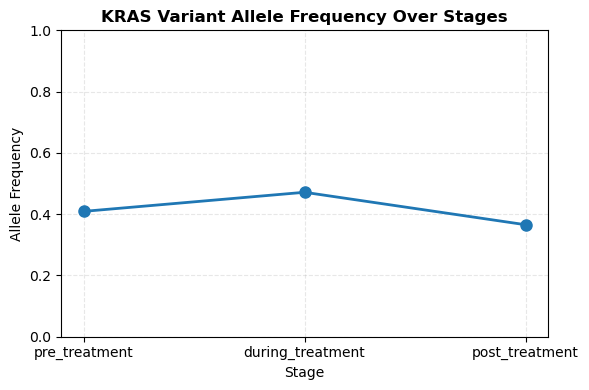

In [ ]:
# Plot allele frequency changes over timepoints
timepoint_order = ["pre_treatment", "during_treatment", "post_treatment"]
selected_variant["sample_label"] = pd.Categorical(selected_variant["sample_label"],categories=timepoint_order, ordered=True)
selected_variant_sorted = selected_variant.sort_values("sample_label")
plt.figure(figsize=(6, 4))
plt.plot(selected_variant_sorted["sample_label"],selected_variant_sorted["allele_frequency"],marker="o",linewidth=2, markersize=8,)
plt.title("KRAS Variant Allele Frequency Over Stages", fontsize=12, weight="bold")
plt.xlabel("Stage", fontsize=10)
plt.ylabel("Allele Frequency", fontsize=10)
plt.ylim(0, 1)
plt.grid(True, alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

### Analysis Summary:
_____


**KRAS variant at position 25,209,843 (chr12)** was identified (read depth ≥20x and allele frequency ≥10%) as a persistent mutation across all treatment stages in patient CTC030. 

**KRAS variant at position 25,209,843 (chr12)** has potential as a longitudinal biomarker for colorectal cancer monitoring.

**Limitations:** These findings are based on a single patient case study. This pipeline is explicitly designed to identify variants in circulating tumor DNA for single patients and for a given gene. For this reason, no conclusions can be extrapolated to a population level.